<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#fasttext-models" data-toc-modified-id="fasttext-models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>fasttext models</a></span></li><li><span><a href="#networks" data-toc-modified-id="networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>networks</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

from gensim.models.fasttext import FastText
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Concatenate, Reshape, LSTM, GRU
from keras.optimizers import Adam
from keras.preprocessing.text import text_to_word_sequence

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


# fasttext models

In [3]:
df_chats_raw = pd.read_csv('../data/clean_text.csv')

In [4]:
class SentenceIterator(object):
    texts = None

    def __init__(self, texts):
        self.texts = texts

    def __iter__(self):
        for text in self.texts:
            yield text_to_word_sequence(text, lower=False)

In [5]:
def build_fasttext(size=100):
    path = '../data/fasttext_chats_%d.pkl' % size
    if os.path.exists(path):
        m = FastText.load(path)
    else:
        m = FastText(SentenceIterator(df_chats_raw['clean_text']), min_count=5, size=size, workers=-1)
        m.save(path)
    return m

In [6]:
def text2vec(text, m=None, size=None):
    vectors = []
    for word in text_to_word_sequence(text):
        try:
            v = m.wv[word]
            vectors.append(v)
        except Exception as e:
            pass
    if not vectors:
        return np.zeros((size, ))
    return sum(vectors) / len(vectors)

In [7]:
def build_vectors(texts, size=None):
    t_model = build_fasttext(size)
    vectors = list(map(lambda x: text2vec(x, m=t_model, size=size), texts))
    return np.array(vectors)

# networks

In [8]:
TICKER = 'ETH'

In [9]:
df_prices_raw = pd.read_csv('../data/train/tickers_train.csv', index_col=0)

In [10]:
df_prices_raw['timestamp'] = pd.to_datetime(df_prices_raw['datetime']).apply(lambda x: x.timestamp())

In [11]:
df_prices = df_prices_raw[df_prices_raw['ticker'] == TICKER].copy()

In [12]:
df_chats = df_chats_raw[df_chats_raw['clean_text'].str.contains(TICKER.lower())].copy()

In [13]:
chat_ids = list(df_chats['chat_id'].unique())
chat_ids.sort()
chat2ind = {chat_id: i for i, chat_id in enumerate(chat_ids)}

sender_ids = list(df_chats['sender_id'].unique())
sender_ids.sort()
sender2ind = {sender_id: i for i, sender_id in enumerate(sender_ids)}

In [14]:
df_chats['chat_ind'] = df_chats['chat_id'].apply(lambda x: chat2ind[x])
df_chats['sender_ind'] = df_chats['sender_id'].apply(lambda x: sender2ind[x])

In [15]:
df_chats['ind'] = list(range(df_chats.shape[0]))

In [16]:
vectors100 = build_vectors(df_chats['clean_text'], size=100)

In [17]:
df_chats.shape, vectors100.shape

((29788, 17), (29788, 100))

In [19]:
tsne = TSNE()
coords = tsne.fit_transform(vectors100)

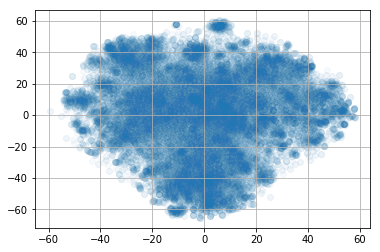

In [25]:
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.03)
plt.grid()
plt.show()

In [21]:
df_chats['x'] = coords[:, 0]
df_chats['y'] = coords[:, 1]

In [29]:
def output_messages(X, Y, count=5):
# X = 8
# Y = 55

    df_chats['center_x'] = X
    df_chats['center_y'] = Y

    df_chats['d'] = (df_chats['center_x'] - df_chats['x']) ** 2  +(df_chats['center_y'] - df_chats['y']) ** 2
    
    for text in df_chats.sort_values('d')[:count]['text']:
        print(text)

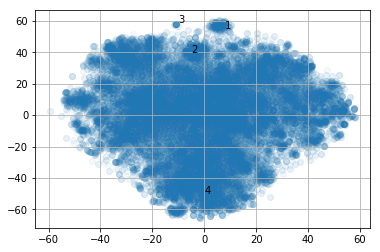

In [41]:
plt.scatter(coords[:, 0], coords[:, 1], alpha=0.05)
plt.grid()
plt.annotate('1', xy=(8, 55))
plt.annotate('2', xy=(-5, 40))
plt.annotate('3', xy=(-10, 59))
plt.annotate('4', xy=(0, -50))
plt.show()

In [43]:
print(1, '---')
output_messages(8, 55)
print(2, '---')
output_messages(-5, 40)
print(3, '---')
output_messages(-10, 59)
print(4, '---')
output_messages(0, -50)

1 ---
swingtrade onto something else if u think the grass is greener elsewhere
you got something u can put on craigslist or ebay lmao
if u know there is something highly anticipated coming up
if u withdraw idh they are not taking eth thay are takind idh....
if u say something big... world changing..... thats just the sentiment
2 ---
no, randy, we have given an opportunity to come in for all previous participants( whoever struck with refund we will look into case by case basis and provide the eth rate for them)  so we ended the peg-ging.
good news for ncr family 
we are happy to announce that very soon ncrcoin available for tradding in hitbtc exchange with ncr/btc or ncr/eth pair
if we are off eth blockchain does that mean we don’t get the movement with btc?? so we run our own race??
if our kyc fails do we get refunded our eth
so that we create together our community culture
3 ---
yes, you can. we accept payment in bitcoin, litecoin, doge coin, ethereum and bitcoin cash 😊
yes, we accept